In [15]:
import sys
from pathlib import Path
# Get the repository root (2 levels up from current notebook)
repo_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA
from Mod_Productor3 import Mod_Productor as MP
# Instantiate the Template class


Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

In [16]:
# If the dataframes have any missing values on the 'Tratamiento' column, delete those rows
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]):
    if df['Tratamiento'].isnull().any():
        df.dropna(subset=['Tratamiento'], inplace=True)
        print(f"Dropped missing 'Tratamiento' rows in df{i}")


Dropped missing 'Tratamiento' rows in df4
Dropped missing 'Tratamiento' rows in df10


In [17]:
# Lets add the column 'Sana' to all dataframes
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    # Index plants within each 'Tratamiento' category (starting from 1 for each category)
    if 'Planta' not in df.columns:
        plant_numbers = []
        for tratamiento in df['Tratamiento'].unique():
            category_mask = df['Tratamiento'] == tratamiento
            n_plants_in_category = category_mask.sum()
            # Create plant numbers from 1 to n for this category
            plant_numbers_for_category = list(range(1, n_plants_in_category + 1))
            
            # Add plant numbers in the correct order matching the dataframe rows
            for idx in df[category_mask].index:
                plant_numbers.append(plant_numbers_for_category.pop(0))
        
        df.insert(1, 'Planta', plant_numbers)
        print(f"df{i}: Added 'Planta' column by 'Tratamiento' categories")
        for tratamiento in df['Tratamiento'].unique():
            count = sum(df['Tratamiento'] == tratamiento)
            print(f"  {tratamiento}: {count} plants")
    
    # Now add 'Sana' and drop 'Tratamiento'
    df.insert(1, 'Sana', df['Tratamiento'].apply(lambda x: 1 if x == 'Control' else 0))
    df.drop(columns=['Tratamiento'], inplace=True)

# Now select 6 numbers at random from 1 to 30 for plant selection
np.random.seed(42)  # For reproducibility
selected_plants = np.random.choice(range(1, 31), size=4, replace=False)
print("Selected plants for analysis:", selected_plants)

# From the plants selected, lets remove the rows corresponding to those plants from 
# each dataframe and add them to a test dataframe
test_dfs = []
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    test_df = df[df['Planta'].isin(selected_plants)].copy()
    test_dfs.append(test_df)
    # Remove these rows from the original dataframe
    df.drop(index=test_df.index, inplace=True)
    print(f"df{i}: Moved {len(test_df)} rows to test set")

df0: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 27 plants
  Ral_EH: 30 plants
  Fus_EH_Ral: 30 plants
df1: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df2: Added 'Planta' column by 'Tratamiento' categories
  Control: 28 plants
  Ralstonia: 29 plants
  Fusarium: 29 plants
  E_Hidrico: 28 plants
  Ral_Fus: 29 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df3: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 28 plants
  Fus_EH_Ral: 30 plants
df4: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fus

In [18]:
# Combine all test dataframes into one
test_df_combined = pd.concat(test_dfs, ignore_index=True)
print(f"Combined test dataframe has {len(test_df_combined)} rows")
test_df_combined.head(10)

Combined test dataframe has 464 rows


,Sana,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1,16,0.065379,0.063930,0.063162,0.063767,0.063386,0.061034,0.057089,0.053973,...,0.041582,0.041465,0.041463,0.041288,0.040981,0.040747,0.040418,0.040234,0.040180,0.040011
1,1,18,0.071688,0.072464,0.073471,0.074896,0.074491,0.072490,0.070665,0.065283,...,0.036699,0.036554,0.036464,0.036364,0.036334,0.036298,0.036259,0.036150,0.036069,0.035952
2,1,24,0.054900,0.054559,0.051083,0.056556,0.060319,0.058287,0.052547,0.047870,...,0.040588,0.040373,0.040147,0.039938,0.039695,0.039485,0.039301,0.039135,0.038963,0.038863
3,1,28,0.053271,0.051633,0.052123,0.054103,0.055772,0.054979,0.050029,0.046028,...,0.030300,0.030244,0.030310,0.030322,0.030469,0.030398,0.030161,0.030035,0.029861,0.029700
4,0,16,0.038046,0.040249,0.038693,0.043328,0.046173,0.044545,0.040426,0.035936,...,0.042807,0.042631,0.042359,0.042219,0.042159,0.042039,0.041955,0.041859,0.041688,0.041660
5,0,18,0.030751,0.031507,0.028468,0.032771,0.037119,0.037244,0.032353,0.026213,...,0.043566,0.043312,0.043028,0.042847,0.042702,0.042565,0.042508,0.042396,0.042265,0.042135
6,0,24,0.033870,0.031191,0.025911,0.033189,0.036553,0.033357,0.031612,0.029107,...,0.042719,0.042575,0.042276,0.042146,0.042060,0.041972,0.041969,0.041914,0.041794,0.041782
7,0,28,0.041691,0.045458,0.045500,0.045728,0.045459,0.044313,0.042296,0.038745,...,0.037489,0.037330,0.037198,0.037064,0.036893,0.036759,0.036672,0.036590,0.036514,0.036448
8,0,16,0.062141,0.061420,0.060890,0.061787,0.062611,0.062088,0.059410,0.054802,...,0.040694,0.040487,0.040416,0.040233,0.039854,0.039698,0.039682,0.039580,0.039522,0.039453
9,0,18,0.055542,0.055868,0.050314,0.052970,0.054913,0.053557,0.051653,0.047319,...,0.039337,0.039138,0.038902,0.038735,0.038675,0.038517,0.038300,0.038182,0.038097,0.037965


In [19]:
# Finally, we can drop the 'Planta' column from all dataframes 
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    if 'Planta' in df.columns:
        df.drop(columns=['Planta'], inplace=True)

In [20]:
test_df_combined.head()

,Sana,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,1,16,0.065379,0.063930,0.063162,0.063767,0.063386,0.061034,0.057089,0.053973,...,0.041582,0.041465,0.041463,0.041288,0.040981,0.040747,0.040418,0.040234,0.040180,0.040011
1,1,18,0.071688,0.072464,0.073471,0.074896,0.074491,0.072490,0.070665,0.065283,...,0.036699,0.036554,0.036464,0.036364,0.036334,0.036298,0.036259,0.036150,0.036069,0.035952
2,1,24,0.054900,0.054559,0.051083,0.056556,0.060319,0.058287,0.052547,0.047870,...,0.040588,0.040373,0.040147,0.039938,0.039695,0.039485,0.039301,0.039135,0.038963,0.038863
3,1,28,0.053271,0.051633,0.052123,0.054103,0.055772,0.054979,0.050029,0.046028,...,0.030300,0.030244,0.030310,0.030322,0.030469,0.030398,0.030161,0.030035,0.029861,0.029700
4,0,16,0.038046,0.040249,0.038693,0.043328,0.046173,0.044545,0.040426,0.035936,...,0.042807,0.042631,0.042359,0.042219,0.042159,0.042039,0.041955,0.041859,0.041688,0.041660


In [21]:
# Produce the models for each dataframe
models = {}
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    print(f"Producing model for DataFrame df{i}...")
    modelo = MP(df, target = 'Sana', test_size=0.2, random_state=42, PCA_components=20)
    modelo.train_model()
    models[f'model_df{i}'] = modelo

Producing model for DataFrame df0...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [7.26250803e-01 1.91802674e-01 3.22332465e-02 2.22554428e-02
 1.07296596e-02 9.02330190e-03 2.13912187e-03 1.86577509e-03
 1.38665848e-03 5.24206696e-04 4.45756995e-04 2.78300199e-04
 2.34935467e-04 1.91318627e-04 1.44878774e-04 9.40541686e-05
 6.09459790e-05 5.67527198e-05 4.93370677e-05 3.43200884e-05]
Total explained variance: 0.9998

Class distribution before SMOTE:
  Class 0 (Unhealthy): 153
  Class 1 (Healthy): 25

Class distribution after SMOTE:
  Class 0 (Unhealthy): 153
  Class 1 (Healthy): 153

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9770
  Precision: 0.9572
  Recall: 1.0000
  F1-Score: 0.9779
  ROC-AUC: 0.9998
Producing model for DataFrame df1...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [6.25519387e-01 2.12433346e-01 5.96277793e-02 4.45048075e-02
 3.25900486e-02 1.44928834e-02 3.88790287e-03 2.14235984e-03
 1.13213328e-03 8.65457399e-04 5.97923979e-04 4.68752115e-04
 4.00064189e-04 2.95500907e-04 2.25321819e-04 1.89888092e-04
 1.14843714e-04 9.78871393e-05 6.32577469e-05 6.02176811e-05]
Total explained variance: 0.9997

Class distribution before SMOTE:
  Class 0 (Unhealthy): 181
  Class 1 (Healthy): 26

Class distribution after SMOTE:
  Class 0 (Unhealthy): 181
  Class 1 (Healthy): 181

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9887
  Precision: 0.9785
  Recall: 1.0000
  F1-Score: 0.9890
  ROC-AUC: 1.0000
Producing model for DataFrame df3...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [6.95926461e-01 1.81443202e-01 4.21948178e-02 3.72641742e-02
 1.53596713e-02 1.50481691e-02 5.60864895e-03 2.19137139e-03
 1.27983287e-03 8.25198699e-04 6.56540633e-04 4.31685992e-04
 3.64120164e-04 3.02525496e-04 2.72216341e-04 1.48135752e-04
 1.27423540e-04 1.15880215e-04 6.34632537e-05 5.80969966e-05]
Total explained variance: 0.9997

Class distribution before SMOTE:
  Class 0 (Unhealthy): 179
  Class 1 (Healthy): 26

Class distribution after SMOTE:
  Class 0 (Unhealthy): 179
  Class 1 (Healthy): 179

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9500
  Precision: 0.9279
  Recall: 1.0000
  F1-Score: 0.9582
  ROC-AUC: 0.9972
Producing model for DataFrame df4...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [6.92194748e-01 1.72165416e-01 4.38278108e-02 4.11865249e-02
 2.14157204e-02 1.26709182e-02 6.81682642e-03 2.53383804e-03
 2.23875832e-03 1.17903552e-03 7.75637604e-04 7.22524465e-04
 5.21989680e-04 3.04193824e-04 2.89595805e-04 1.99576134e-04
 1.74515812e-04 1.58263335e-04 1.27880732e-04 1.01194589e-04]
Total explained variance: 0.9996

Class distribution before SMOTE:
  Class 0 (Unhealthy): 175
  Class 1 (Healthy): 25

Class distribution after SMOTE:
  Class 0 (Unhealthy): 175
  Class 1 (Healthy): 175

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9943
  Precision: 0.9892
  Recall: 1.0000
  F1-Score: 0.9944
  ROC-AUC: 0.9989
Producing model for DataFrame df5...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [6.53130925e-01 2.28774495e-01 5.30921407e-02 2.57123049e-02
 1.77421101e-02 1.36791502e-02 2.29973444e-03 1.51039557e-03
 9.04295314e-04 7.92640235e-04 5.73180751e-04 3.77489057e-04
 3.08938560e-04 2.24315959e-04 1.81390779e-04 1.46390509e-04
 1.06115773e-04 7.32979818e-05 6.35579618e-05 4.51513243e-05]
Total explained variance: 0.9997

Class distribution before SMOTE:
  Class 0 (Unhealthy): 180
  Class 1 (Healthy): 26

Class distribution after SMOTE:
  Class 0 (Unhealthy): 180
  Class 1 (Healthy): 180

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9583
  Precision: 0.9283
  Recall: 1.0000
  F1-Score: 0.9615
  ROC-AUC: 0.9955
Producing model for DataFrame df6...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [8.28900447e-01 1.03260559e-01 2.54095559e-02 1.83687774e-02
 1.06172341e-02 6.13947804e-03 2.50863522e-03 1.28559833e-03
 9.81489875e-04 5.67934440e-04 3.99709729e-04 3.25068506e-04
 2.49465446e-04 2.13115197e-04 1.78037607e-04 1.09051240e-04
 9.62230002e-05 6.70308125e-05 5.72869971e-05 4.61996344e-05]
Total explained variance: 0.9998

Class distribution before SMOTE:
  Class 0 (Unhealthy): 172
  Class 1 (Healthy): 26

Class distribution after SMOTE:
  Class 0 (Unhealthy): 172
  Class 1 (Healthy): 172

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9739
  Precision: 0.9559
  Recall: 1.0000
  F1-Score: 0.9763
  ROC-AUC: 0.9983
Producing model for DataFrame df7...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [6.79345537e-01 2.89581627e-01 1.53207111e-02 7.27878592e-03
 2.85829495e-03 2.30632693e-03 1.10319627e-03 6.73057448e-04
 5.98552632e-04 2.77130208e-04 2.01778526e-04 9.70552756e-05
 8.25708861e-05 6.17434139e-05 4.65803373e-05 4.02771925e-05
 3.34049321e-05 1.67312303e-05 1.24905852e-05 1.08081469e-05]
Total explained variance: 0.9999

Class distribution before SMOTE:
  Class 0 (Unhealthy): 160
  Class 1 (Healthy): 26

Class distribution after SMOTE:
  Class 0 (Unhealthy): 160
  Class 1 (Healthy): 160

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



TRAINING COMPLETE
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

Best scores across all metrics:
  Accuracy: 0.9969
  Precision: 1.0000
  Recall: 0.9938
  F1-Score: 0.9968
  ROC-AUC: 0.9998
Producing model for DataFrame df8...
Original feature count: 2151
Features after PCA: 20
Explained variance ratio: [9.43237906e-01 3.38070880e-02 1.57554939e-02 3.51705840e-03
 1.49796176e-03 9.15992156e-04 3.86399827e-04 2.55528067e-04
 1.57038987e-04 1.32551341e-04 9.17844600e-05 6.88213714e-05
 3.94917595e-05 3.33197081e-05 2.34714703e-05 1.72797766e-05
 1.47152853e-05 8.58074771e-06 7.26399857e-06 6.87679058e-06]
Total explained variance: 1.0000

Class distribution before SMOTE:
  Class 0 (Unhealthy): 155
  Class 1 (Healthy): 26

Class distribution after SMOTE:
  Class 0 (Unhealthy): 155
  Class 1 (Healthy): 155

Starting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

TRAINING COMPLETE
Best parameters found:  {'C

In [22]:
# First make a prediction on the test samples with ALL models
df_predictions = test_df_combined.copy()

df_predictions.drop(columns=['Planta'], errors='ignore', inplace=True)


# For each model, make predictions on ALL test samples
for model_num in range(0, 16):
    modelo = models[f'model_df{model_num}']
    
    # Prepare all test data (removing 'Sana' and 'Day' columns, keeping only wavelength features)
    feature_columns = [col for col in df_predictions.columns if col not in ['Sana', 'Day'] and not str(col).startswith('pred_')]
    X_test_all = df_predictions[feature_columns].values
    
    # Make predictions with this model on all test samples
    y_pred = modelo.predict(X_test_all)
    
    # Add predictions as a new column
    df_predictions[f'pred_{model_num}'] = y_pred
    print(f"Model {model_num} predictions added to column 'pred_{model_num}'")


# Display the first few rows
print("\nFirst few rows of predictions:")
print(df_predictions.head())

# Save the predictions to a CSV file
df_predictions.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")

# Show column names to verify
print("\nColumns in df_predictions:")
print(df_predictions.columns.tolist())

Model 0 predictions added to column 'pred_0'
Model 1 predictions added to column 'pred_1'
Model 2 predictions added to column 'pred_2'
Model 3 predictions added to column 'pred_3'
Model 4 predictions added to column 'pred_4'
Model 5 predictions added to column 'pred_5'
Model 6 predictions added to column 'pred_6'
Model 7 predictions added to column 'pred_7'
Model 8 predictions added to column 'pred_8'
Model 9 predictions added to column 'pred_9'
Model 10 predictions added to column 'pred_10'
Model 11 predictions added to column 'pred_11'
Model 12 predictions added to column 'pred_12'
Model 13 predictions added to column 'pred_13'
Model 14 predictions added to column 'pred_14'
Model 15 predictions added to column 'pred_15'

First few rows of predictions:
   Sana       350       351       352       353       354       355       356  \
0     1  0.065379  0.063930  0.063162  0.063767  0.063386  0.061034  0.057089   
1     1  0.071688  0.072464  0.073471  0.074896  0.074491  0.072490  0.070

In [23]:
# Drop the columns of the wavelength features
df_predictions.drop(columns=feature_columns, inplace=True)

In [24]:
df_predictions.head(10)


,Sana,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15
0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0
2,1,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1
3,1,1,0,0,0,1,0,1,0,1,1,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0
9,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0


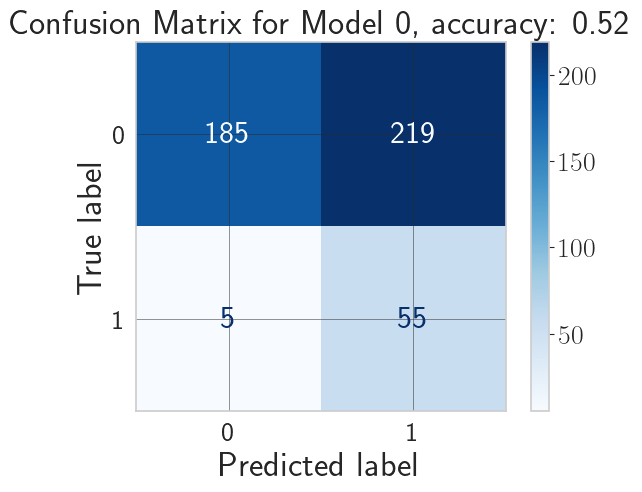

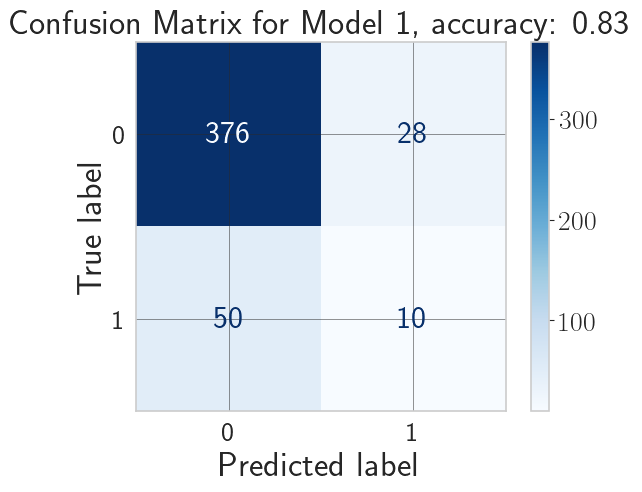

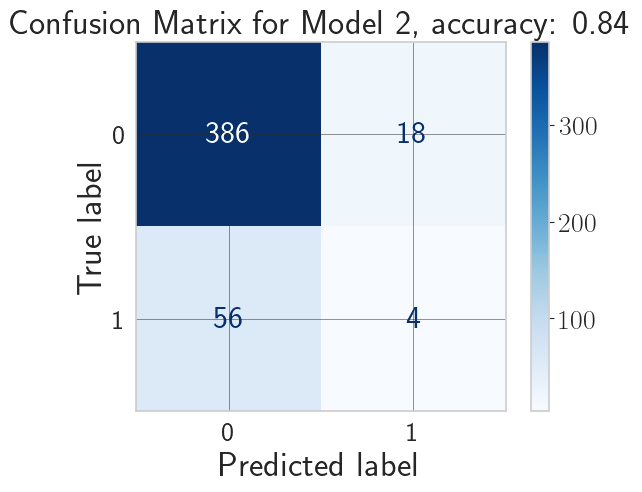

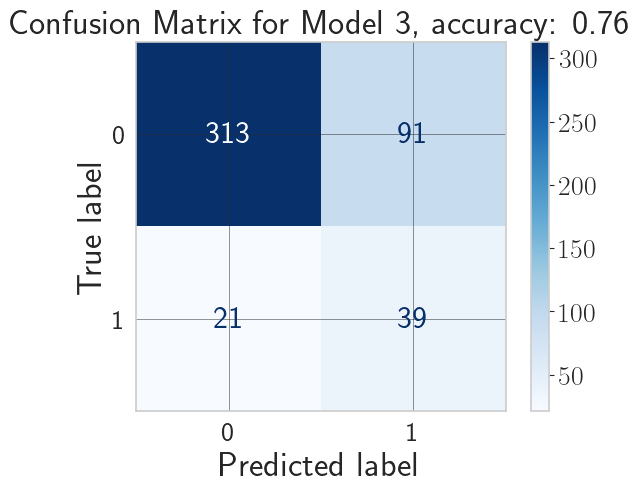

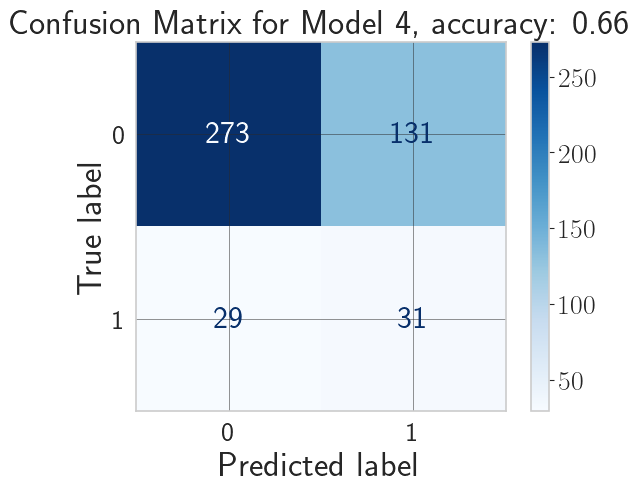

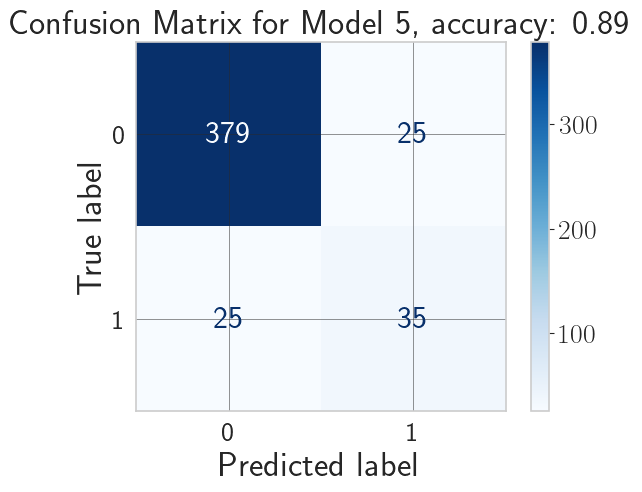

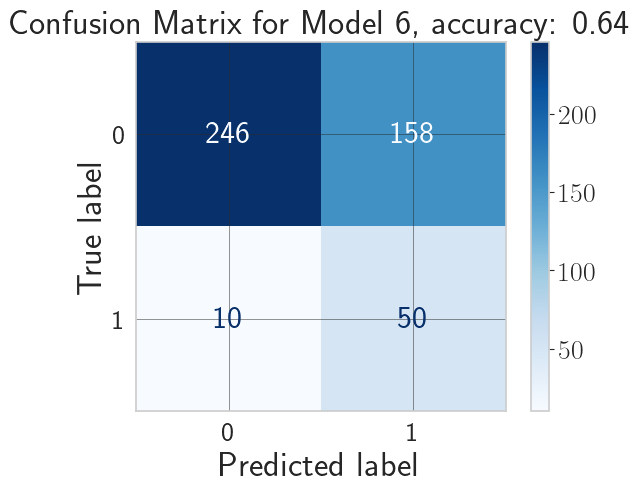

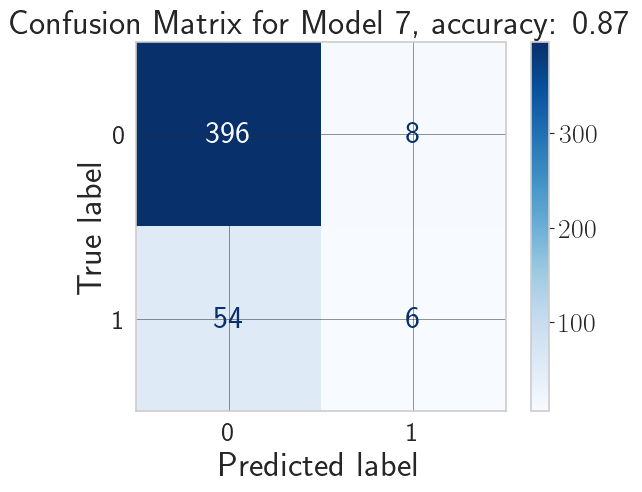

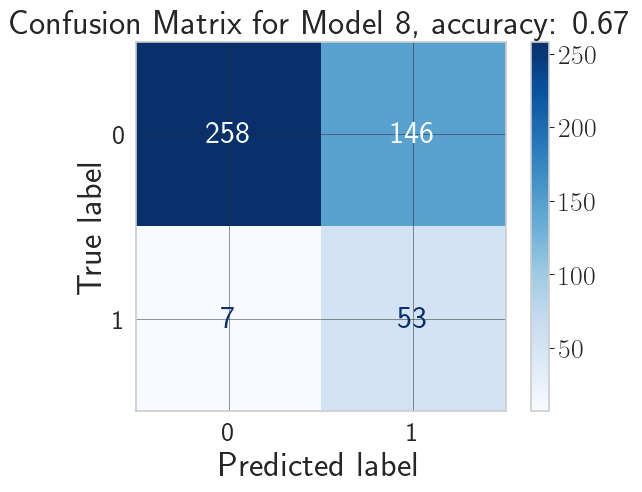

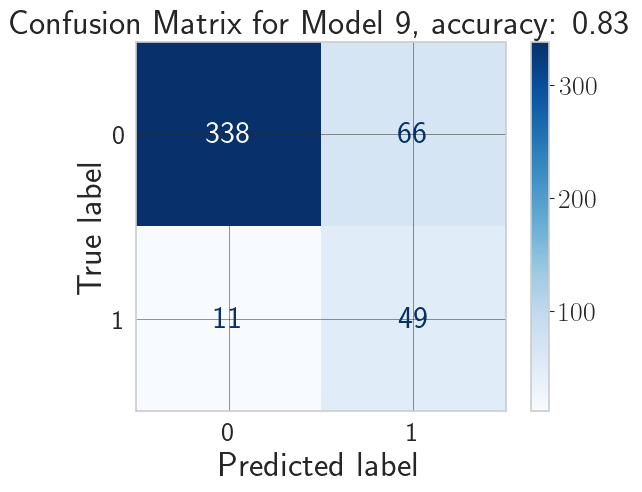

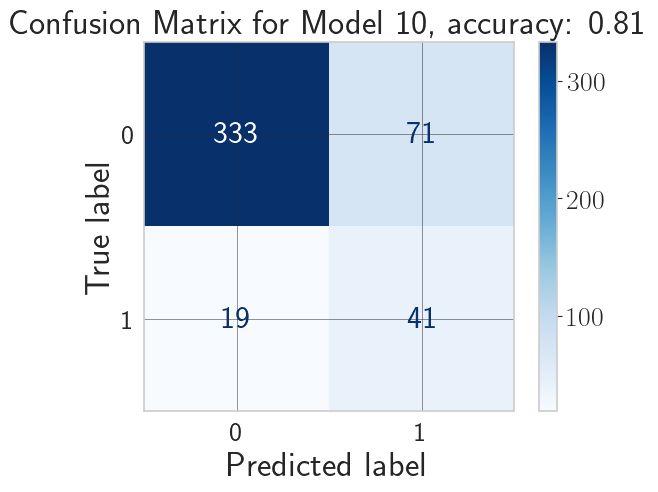

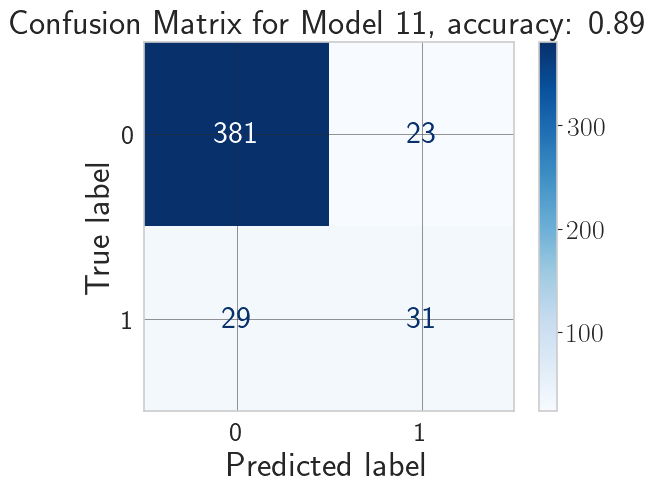

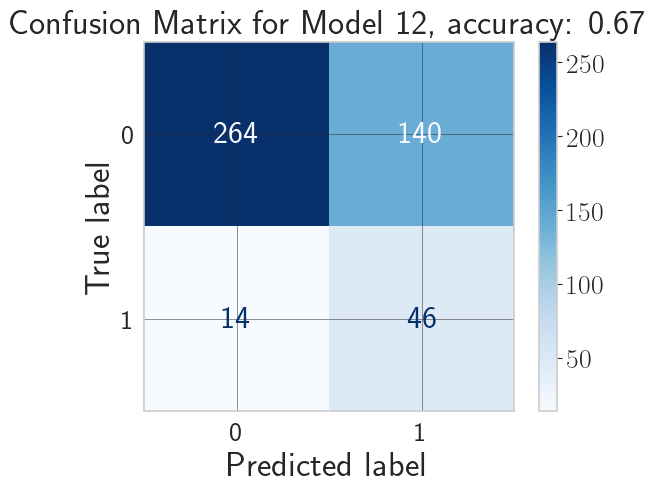

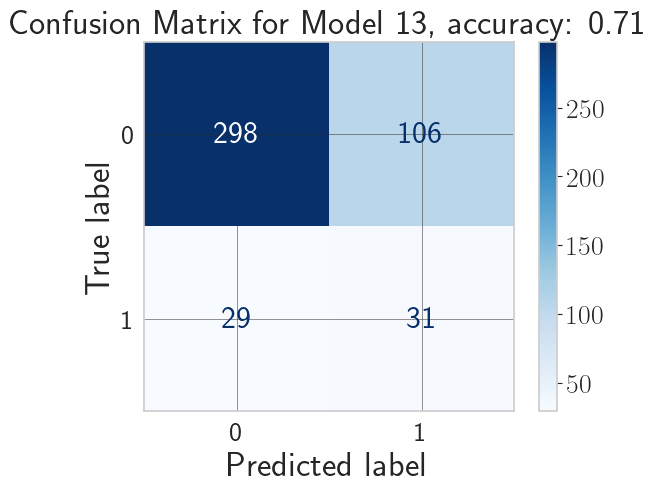

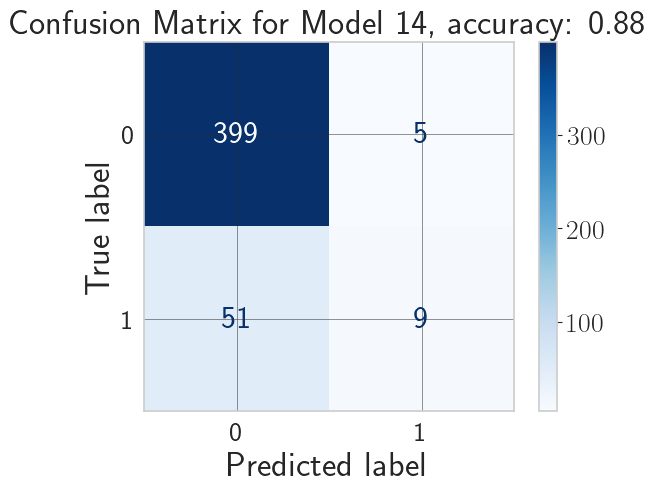

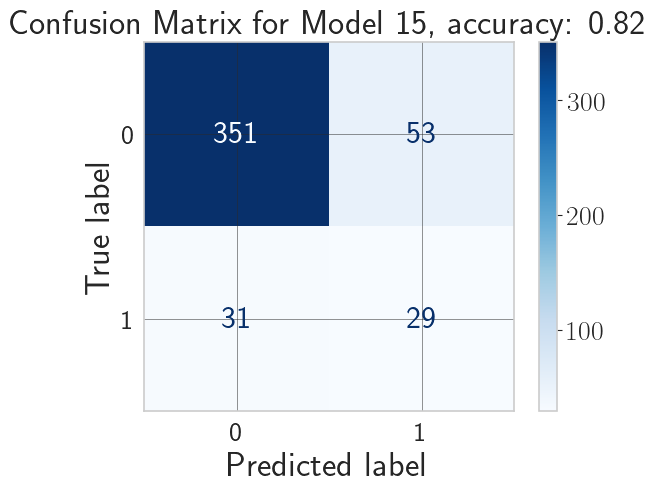

In [25]:
# Confussion matrix for each model
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import f1_score
for model_num in range(0, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    # plot confusion matrix with title corresponding to model number
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)
    # Set title and add accuracy in the title
    f1 = f1_score(y_true, y_pred)
    disp.ax_.set_title(f'Confusion Matrix for Model {model_num}, accuracy: {accuracy:.2f}')
    plt.show()

In [26]:
# Lets put the accuracy of all models in a csv file
accuracy_list = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_list.append({'Model': model_num, 'Accuracy': accuracy})
accuracy_df = pd.DataFrame(accuracy_list)
accuracy_df.to_csv('model3_accuracies.csv', index=False)
# Now put the f1 score of all models in a csv file
from sklearn.metrics import f1_score
f1_list = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    f1 = f1_score(y_true, y_pred)
    f1_list.append({'Model': model_num, 'F1_Score': f1})
f1_df = pd.DataFrame(f1_list)
f1_df.to_csv('model3_f1_scores.csv', index=False)

### Logistic Regression with weighted features from base models

Model 1 accuracy: 0.8319
Model 2 accuracy: 0.8405
Model 3 accuracy: 0.7586
Model 4 accuracy: 0.6552
Model 5 accuracy: 0.8922
Model 6 accuracy: 0.6379
Model 7 accuracy: 0.8664
Model 8 accuracy: 0.6703
Model 9 accuracy: 0.8341
Model 10 accuracy: 0.8060
Model 11 accuracy: 0.8879
Model 12 accuracy: 0.6681
Model 13 accuracy: 0.7091
Model 14 accuracy: 0.8793
Model 15 accuracy: 0.8190

Performance weights: [0.83189655 0.84051724 0.75862069 0.65517241 0.89224138 0.63793103
 0.86637931 0.67025862 0.83405172 0.80603448 0.88793103 0.66810345
 0.70905172 0.87931034 0.81896552]
Min weight: 0.6379, Max weight: 0.8922

Meta-Model Accuracy: 0.9032

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        81
           1       0.71      0.42      0.53        12

    accuracy                           0.90        93
   macro avg       0.82      0.70      0.74        93
weighted avg       0.89      0.90      0.89        93


Model Co

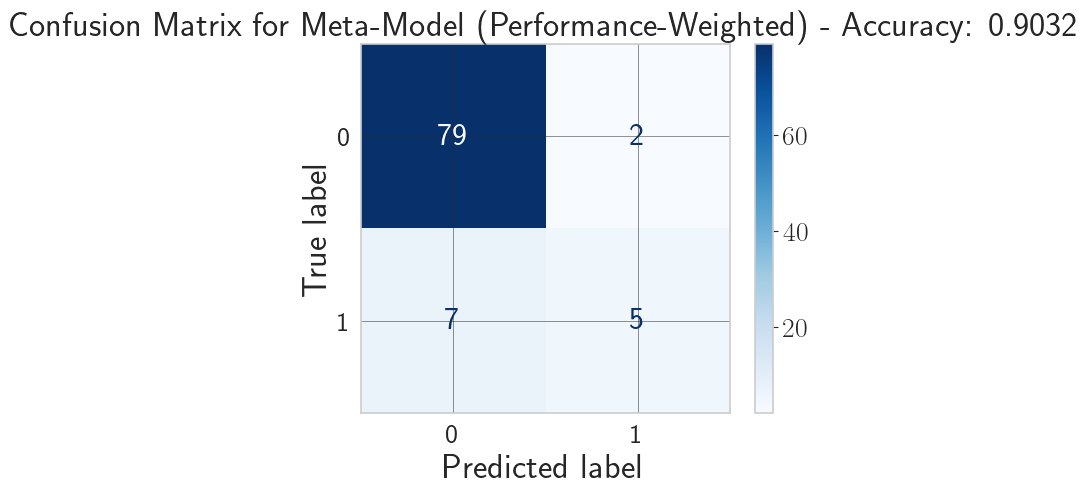

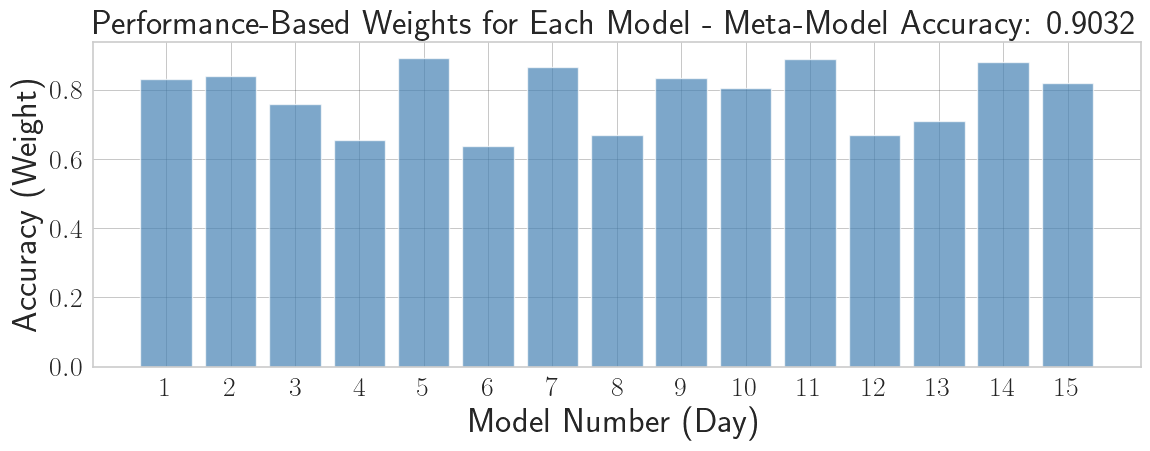

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Prepare data for meta-model
X_meta = df_predictions[[f'pred_{i}' for i in range(1, 16)]].values
y_meta = df_predictions['Sana'].values

# Calculate performance-based weights using accuracy of each model
performance_weights = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    accuracy = accuracy_score(y_true, y_pred)
    performance_weights.append(accuracy)
    print(f"Model {model_num} accuracy: {accuracy:.4f}")

# Convert to numpy array
weights = np.array(performance_weights)
print(f"\nPerformance weights: {weights}")
print(f"Min weight: {weights.min():.4f}, Max weight: {weights.max():.4f}")

# Apply weights to each feature (multiply each column by its accuracy weight)
X_meta_weighted = X_meta * weights

# Split data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta_weighted, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)

# Train meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

# Evaluate
y_pred_meta = meta_model.predict(X_test_meta)
print(f"\nMeta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_meta, y_pred_meta))

# Show feature importance (coefficients after weighting)
print("\nModel Coefficients (after performance weighting):")
for i, coef in enumerate(meta_model.coef_[0], 1):
    print(f"  Model {i} (weight={weights[i-1]:.4f}): coef={coef:.4f}")

# Confusion matrix for meta-model
disp = ConfusionMatrixDisplay.from_predictions(y_test_meta, y_pred_meta, cmap=plt.cm.Blues)
disp.ax_.set_title(f'Confusion Matrix for Meta-Model (Performance-Weighted) - Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}')
plt.show()

# Visualize the performance weights
plt.figure(figsize=(12, 5))
plt.bar(range(1, 16), weights, color='steelblue', alpha=0.7)
plt.xlabel('Model Number (Day)')
plt.ylabel('Accuracy (Weight)')
plt.title(f'Performance-Based Weights for Each Model - Meta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}')
plt.xticks(range(1, 16))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Logistic Regression with weighted features (Own weights)

Model 1 - Accuracy: 0.8319, Weight (Acc * Day): 0.8319
Model 2 - Accuracy: 0.8405, Weight (Acc * Day): 1.6810
Model 3 - Accuracy: 0.7586, Weight (Acc * Day): 2.2759
Model 4 - Accuracy: 0.6552, Weight (Acc * Day): 2.6207
Model 5 - Accuracy: 0.8922, Weight (Acc * Day): 4.4612
Model 6 - Accuracy: 0.6379, Weight (Acc * Day): 3.8276
Model 7 - Accuracy: 0.8664, Weight (Acc * Day): 6.0647
Model 8 - Accuracy: 0.6703, Weight (Acc * Day): 5.3621
Model 9 - Accuracy: 0.8341, Weight (Acc * Day): 7.5065
Model 10 - Accuracy: 0.8060, Weight (Acc * Day): 8.0603
Model 11 - Accuracy: 0.8879, Weight (Acc * Day): 9.7672
Model 12 - Accuracy: 0.6681, Weight (Acc * Day): 8.0172
Model 13 - Accuracy: 0.7091, Weight (Acc * Day): 9.2177
Model 14 - Accuracy: 0.8793, Weight (Acc * Day): 12.3103
Model 15 - Accuracy: 0.8190, Weight (Acc * Day): 12.2845

Performance weights (Accuracy * Day): [ 0.83189655  1.68103448  2.27586207  2.62068966  4.4612069   3.82758621
  6.06465517  5.36206897  7.50646552  8.06034483  9.767

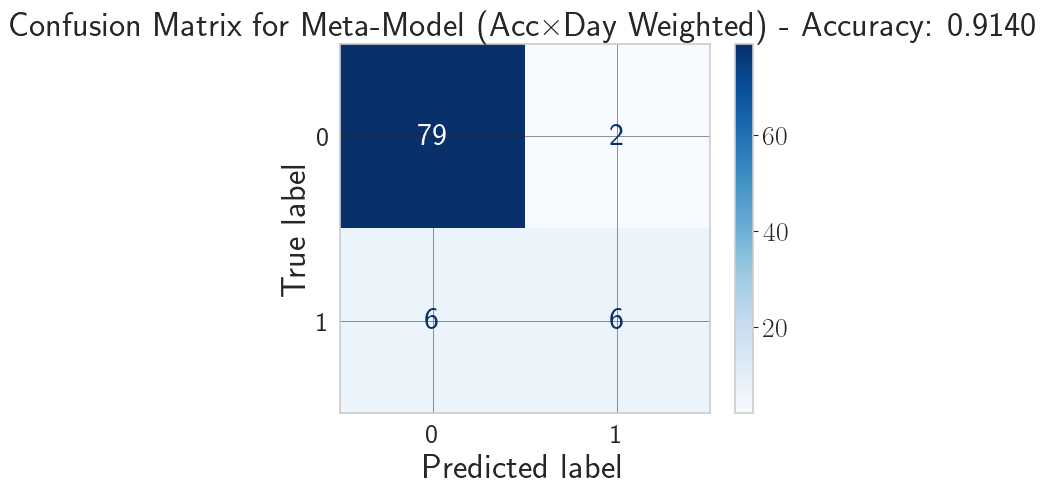

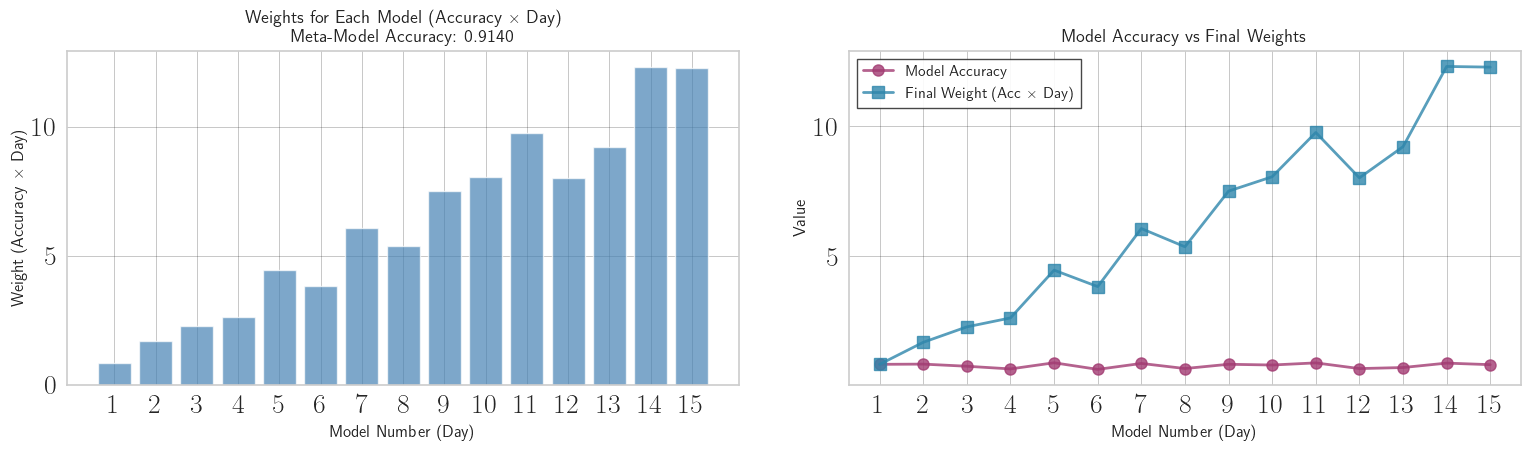

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Prepare data for meta-model
X_meta = df_predictions[[f'pred_{i}' for i in range(1, 16)]].values
y_meta = df_predictions['Sana'].values

# Calculate performance-based weights using accuracy * day_number
performance_weights = []
for model_num in range(1, 16):
    y_true = df_predictions['Sana'].values
    y_pred = df_predictions[f'pred_{model_num}'].values
    accuracy = accuracy_score(y_true, y_pred)
    
    # NEW: Weight = Accuracy * Day Number (higher days = higher importance)
    weight = accuracy * model_num
    performance_weights.append(weight)
    print(f"Model {model_num} - Accuracy: {accuracy:.4f}, Weight (Acc * Day): {weight:.4f}")

# Convert to numpy array
weights = np.array(performance_weights)
print(f"\nPerformance weights (Accuracy * Day): {weights}")
print(f"Min weight: {weights.min():.4f}, Max weight: {weights.max():.4f}")

# Apply weights to each feature (multiply each column by its weight)
X_meta_weighted = X_meta * weights

# Split data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta_weighted, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)

# Train meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

# Evaluate
y_pred_meta = meta_model.predict(X_test_meta)
print(f"\nMeta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_meta, y_pred_meta))

# Show feature importance (coefficients after weighting)
print("\nModel Coefficients (after Accuracy * Day weighting):")
for i, coef in enumerate(meta_model.coef_[0], 1):
    print(f"  Model {i} (Day {i}, Weight={weights[i-1]:.4f}): coef={coef:.4f}")

# Confusion matrix for meta-model
disp = ConfusionMatrixDisplay.from_predictions(y_test_meta, y_pred_meta, cmap=plt.cm.Blues)
disp.ax_.set_title(f'Confusion Matrix for Meta-Model (Acc×Day Weighted) - Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}')
plt.show()

# Visualize the performance weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Weights
ax1.bar(range(1, 16), weights, color='steelblue', alpha=0.7)
ax1.set_xlabel('Model Number (Day)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Weight (Accuracy × Day)', fontsize=12, fontweight='bold')
ax1.set_title(f'Weights for Each Model (Accuracy × Day)\nMeta-Model Accuracy: {accuracy_score(y_test_meta, y_pred_meta):.4f}', 
              fontsize=13, fontweight='bold')
ax1.set_xticks(range(1, 16))
ax1.grid(True, alpha=0.3)

# Plot 2: Comparison of Accuracy vs Weight
accuracies = [w / i for i, w in enumerate(weights, 1)]  # Back-calculate accuracies
ax2.plot(range(1, 16), accuracies, marker='o', linewidth=2, markersize=8, 
         label='Model Accuracy', color='#A23B72', alpha=0.8)
ax2.plot(range(1, 16), weights, marker='s', linewidth=2, markersize=8, 
         label='Final Weight (Acc × Day)', color='#2E86AB', alpha=0.8)
ax2.set_xlabel('Model Number (Day)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Value', fontsize=12, fontweight='bold')
ax2.set_title('Model Accuracy vs Final Weights', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.set_xticks(range(1, 16))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()